<a href="https://colab.research.google.com/github/Azuremis/make_your_first_gan_with_pytorch/blob/master/handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount drive to read data files
from google.colab import drive
drive.mount("./mount")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./mount


In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MNIST Dstaset class

In [3]:
class MnistDataset(Dataset):
  
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # mage target (label)
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))  # create target tensor 
        target[label] = 1.0  # using one hot encoding

        # image data (normalise from 0-255 to 0-1)
        image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

        # return label, image data and target tensor
        return label, image_values, target

    def plot_image(self, index):
        # visualise image from pixels
        img_arr = self.data_df.iloc[index, 1:].values.reshape(28, 28) 
        plt.title("Label: " + str(self.data_df.iloc[index, 0]))
        plt.imshow(img_arr, interpolation='none', cmap="Blues")
        plt.show()

In [4]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/make_your_first_gan_with_pytorch/mnist_data/mnist_train.csv')

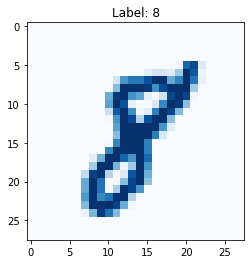

In [5]:
mnist_dataset.plot_image(17)

MNIST discriminator

In [6]:
# set up the discriminator
class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # set up nn layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # set up loss
        self.loss_function = nn.MSELoss()

        # set up optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # set up progress monitors
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # just run the model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate predictions
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # track training progress
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())  # accumulate error
        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass by calcuating gradients
        loss.backward()
        # update learnable parameters
        self.optimiser.step()

    def plot_progress(self):

        df = pd.DataFrame(self.progress, columns=["loss"])    
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5))


Testing the discriminator

In [7]:
# generates random noise
def generate_random(size):
    return torch.rand(size)

In [8]:
discrim = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # train with real data
    discrim.train(image_data_tensor, torch.FloatTensor([1.0]))
    # train with fake data
    discrim.train(generate_random(784), torch.FloatTensor([0.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


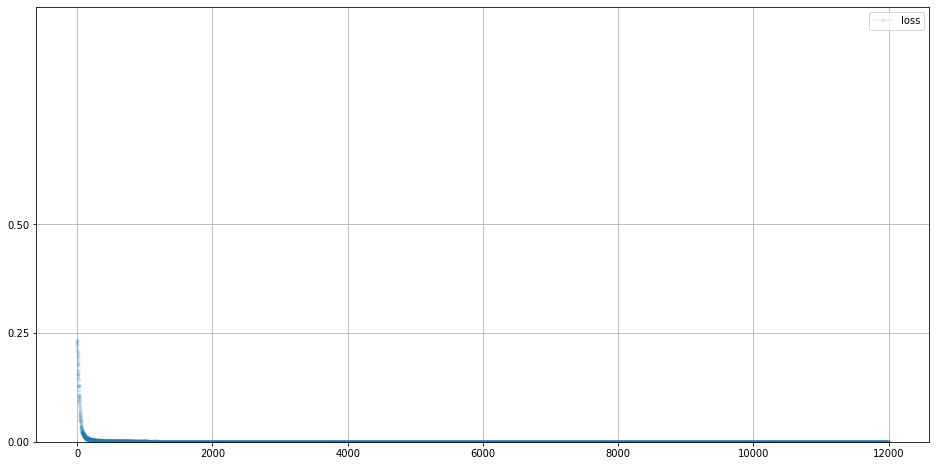

In [9]:
# plot model loss
discrim.plot_progress()

In [10]:
# manual run to check discriminitor is working
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
    print(discrim.forward(image_data_tensor).item())

for i in range(4):
    print(discrim.forward(generate_random(784)).item())


0.9811497926712036
0.9980910420417786
0.9873071908950806
0.996250569820404
0.004762198310345411
0.0067585064098238945
0.005488019902259111
0.0042586857452988625


MNIST generator

In [11]:
class Generator(nn.Module):
    
    def __init__(self):
        # call parent pytorch class
        super().__init__()

        # set up layers
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # set up optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # set up progress tracking
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, discriminator, inputs, targets):
        # calculate network outputs, i.e. generate data
        generator_output = self.forward(inputs)

        # pass generated data to discriminator for classification
        discriminator_output = discriminator.forward(generator_output)

        # calculate loss using discriminator
        loss = discriminator.loss_function(discriminator_output, targets)

        # track progress
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass
        self.backward()
        # update the parameters
        self.optimiser.step()

    def plot_progress():
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker=".",
                grid=True, yticks=(0, 0.25, 0.5))

Checking generator output

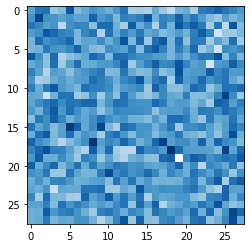

In [12]:
# check that generated data is right type and shape
seed = 0.6
gener = Generator()
output = gener.forward(torch.FloatTensor([seed]))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation="none", cmap="Blues")